In [33]:
import yfinance as yf
import requests
import statsmodels.api as sm
from binance.client import Client as bnb_client
from datetime import datetime
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
#from datetime import datetime
import warnings

pd.set_option("future.no_silent_downcasting", True)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [34]:
# stats function for later
def get_stats(strat_ret):
    stats = {}
    stats['SR'] = strat_ret.mean() / strat_ret.std() * np.sqrt(252)
    stats['ret'] = strat_ret.mean()*252
    stats['vol'] = strat_ret.std()*np.sqrt(252)
    stats = pd.Series(stats)
    return stats

def compounded_rolling(x):
    return (x + 1).prod() - 1

In [35]:
client = bnb_client(tld='US')

In [36]:
#Downloading Data 
def get_binance_px(symbol,freq,start_ts = '2020-01-01',end_ts='2025-09-30'):
    data = client.get_historical_klines(symbol,freq,start_ts,end_ts)
    columns = ['open_time','open','high','low','close','volume','close_time','quote_volume',
    'num_trades','taker_base_volume','taker_quote_volume','ignore']

    data = pd.DataFrame(data,columns = columns)
    
    # Convert from POSIX timestamp (number of millisecond since jan 1, 1970)
    data['open_time'] = data['open_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    data['close_time'] = data['close_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    return data 

univ = ['BTCUSDT','ETHUSDT','ADAUSDT','BNBUSDT','XLMUSDT','DOGEUSDT','LTCUSDT','BCHUSDT','ZENUSDT','HNTUSDT','OXTUSDT','SOLUSDT']
#'SOLUSDT','MATICUSDT','YFIUSDT','DAIUSDT','DOTUSDT','EOSUSDT'
freq = '1h'
px = {}
for x in univ:
    data = get_binance_px(x,freq)
    px[f'{x} Close'] = data.set_index('open_time')['close']

px = pd.DataFrame(px).astype(float)
px = px.reindex(pd.date_range(px.index[0],px.index[-1],freq=freq))
ret = px.pct_change()
for x in univ:
    data = get_binance_px(x,freq)
    ret[f'{x} Vol'] = data.set_index('open_time')['volume']


In [61]:
px=px.ffill()

In [38]:
rets=px[:'20240630']
rets=rets / rets.shift() - 1
rets=rets.dropna(how='all').dropna(how='any')

### Signal Build

In [39]:
corr = rets.rolling(365*24).corr(rets['BTCUSDT Close'])
vol = rets.rolling(365*24).std()
bench_vol= rets['BTCUSDT Close'].rolling(365*24).std()
beta = (corr*vol).divide(bench_vol,axis=0)
resids= rets-beta.multiply(rets['BTCUSDT Close'],0)
resids=resids.drop(columns=['BTCUSDT Close']).dropna(how='all').dropna(how='any',axis=1)

In [40]:
###smoothing signal
smooth_period=72

ma_signal=resids.rolling(smooth_period,min_periods=1).mean().dropna()

In [41]:
z_score_window=365*12

z_score_signal=(ma_signal - ma_signal.rolling(z_score_window).mean())/ma_signal.rolling(z_score_window).std()
z_score_signal=z_score_signal.dropna()

In [42]:
##z score threshold
negate_rank_z = ((z_score_signal <= -3) | (z_score_signal >= 3))*(ma_signal*z_score_signal)
ranked_rank_z = negate_rank_z.rank(1)
demeaned_rank_z = ranked_rank_z.subtract(ranked_rank_z.mean(1),0)
port_rank_z = demeaned_rank_z.divide(demeaned_rank_z.abs().sum(1),0).dropna() #causing NaNs


In Sample SR: 1.9506101617313496


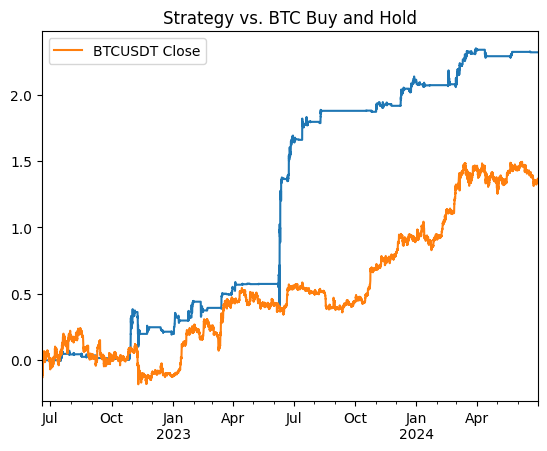

In [43]:
strat_ret_rank = (port_rank_z.shift()*rets[port_rank_z.index.min():]).sum(1)
print(f'In Sample SR: {strat_ret_rank.mean()/strat_ret_rank.std()*np.sqrt(365*24)}')
strat_ret_rank.cumsum().plot()
rets['BTCUSDT Close']['20220618':].cumsum().plot()
plt.title('Strategy vs. BTC Buy and Hold')
plt.legend()
plt.show()

In [44]:
to = (port_rank_z.fillna(0) - port_rank_z.shift().fillna(0)).abs().sum(1)
to
print(f'Strategy Turnover: {to.mean()}')
tcost_bps = 20 # (comissions + slip)
net_ret = strat_ret_rank.subtract(to*tcost_bps*1e-4,fill_value=0)
print(f'SR after t-scosts: {net_ret.mean() / net_ret.std() * np.sqrt(365*24)}')

Strategy Turnover: 0.08744384811359635
SR after t-scosts: 1.5772486740879679


### Function Build

In [45]:
def compounded_rolling(x):
    return (x + 1).prod() - 1

def get_timed_rets(rets,time_frame=1):
    timed_rets = rets.shift(time_frame - 1).resample(f'{time_frame}h').apply(compounded_rolling)
    return timed_rets

def signal_build(timed_rets,bench_timed_rets,resid_window=365*24,ma_window=24,z_score_window=365*24):
    corr = timed_rets.rolling(resid_window).corr(bench_timed_rets)
    vol = timed_rets.rolling(resid_window).std()
    bench_vol= bench_timed_rets.rolling(resid_window).std()
    beta = (corr*vol).divide(bench_vol,axis=0)
    resid = timed_rets-beta.multiply(bench_timed_rets,0)
    resid=resid.drop(columns=['BTCUSDT Close']).dropna(how='all').dropna(how='any',axis=1)   ##resids
    ma_signal=resid.rolling(ma_window).mean().dropna()
    z_score_signal=((ma_signal - ma_signal.rolling(z_score_window).mean())/ma_signal.rolling(z_score_window).std()).dropna()
    t_signal = (ma_signal*z_score_signal).dropna()
    return z_score_signal,t_signal

def signal_transform(z_score_signal,t_signal,z_thresh=2):
    ranked_signal_=((z_score_signal <= -z_thresh) | (z_score_signal >= z_thresh))*(t_signal)
    ranked_signal=ranked_signal_.rank(1)
    demeaned_signal=ranked_signal.subtract(ranked_signal.mean(1),0)
    strat_weights=demeaned_signal.divide(demeaned_signal.abs().sum(1),0).dropna()
    return strat_weights

def port_creation(strat_weights,timed_rets,shift=1):
    port=(strat_weights.shift(shift)*timed_rets).sum(1)
    return port

### Function POC

In [46]:
timed_rets_test=get_timed_rets(rets)

In [47]:
z_score_signal,t_signal=signal_build(timed_rets_test,timed_rets_test['BTCUSDT Close'],365*24,72,365*12)

In [48]:
strat_wgts=signal_transform(z_score_signal,t_signal,3)

In [49]:
port_test=port_creation(strat_wgts,timed_rets_test[strat_wgts.index.min():'20240630'].drop(columns='BTCUSDT Close'))

In [50]:
sr=port_test.mean()/port_test.std()*np.sqrt(365*24)
print(f'In-Sample SR: {sr}')

In-Sample SR: 1.9593072623466523


In [51]:
to_ = (strat_wgts.fillna(0) - strat_wgts.shift().fillna(0)).abs().sum(1)
print(f'Strategy Turnover: {to_.mean()}')
tcost_bps = 20 # (comissions + slip)
net_ret_ = port_test.subtract(to_*tcost_bps*1e-4,fill_value=0)
print(f'In Sample SR after t-costs:{net_ret_.mean() / net_ret_.std() * np.sqrt(365*24)}')

Strategy Turnover: 0.08559248986490778
In Sample SR after t-costs:1.5991574348776574


### Grid Search Build

In [52]:
ma_window=[60,72,84,96]
z_window=[12,24,48,60]
z_threshold=[2.5,2.75,3,3.25,3.5]

from itertools import product

sr_results = []

r = get_timed_rets(rets, 1)
for ma_w, z_w in product(ma_window, z_window):
    z_sig, t_sig = signal_build(r, r['BTCUSDT Close'], 365*24, ma_w, 365*z_w)
    for z_t in z_threshold:
        wgts=signal_transform(z_sig,t_sig,z_t)
        ports=port_creation(wgts,r[wgts.index.min():])
        sharpes=ports.mean()/ports.std()*np.sqrt(365*24)

        sr_results.append({
            'ma_window': ma_w,
            'z_window': z_w,
            'z_threshold': z_t,
            'sharpe_ratio': sharpes
        })

sr_df = pd.DataFrame(sr_results)
#sr_df

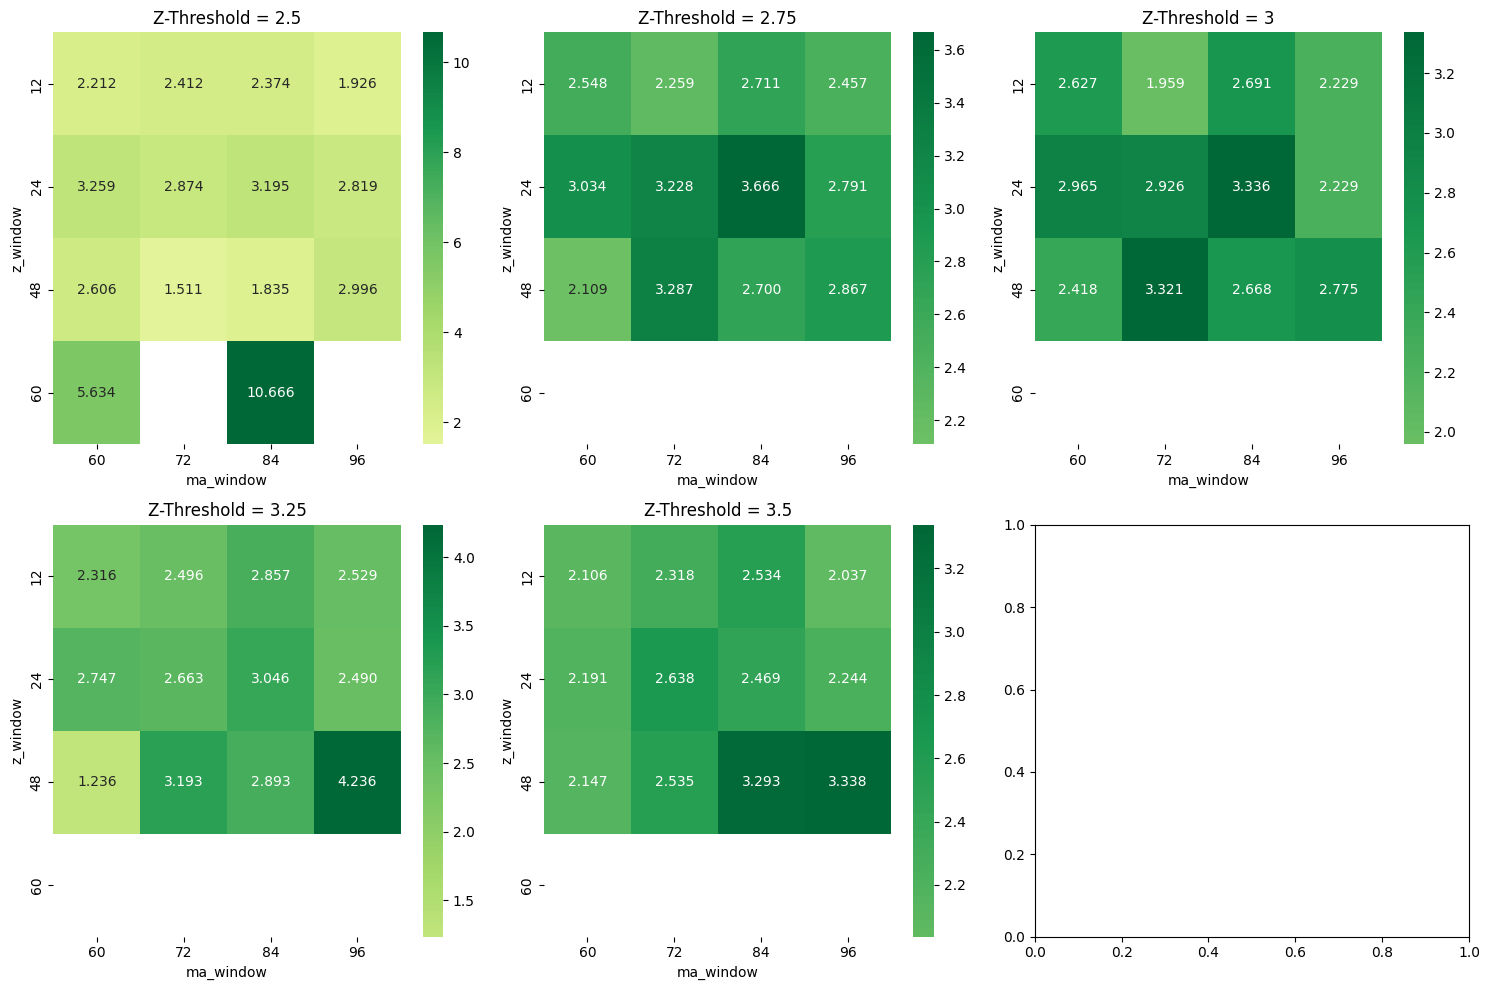

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, z_t in enumerate(z_threshold):
    df_subset = sr_df[sr_df['z_threshold'] == z_t]
    pivot = df_subset.pivot(index='z_window', columns='ma_window', values='sharpe_ratio')
    sns.heatmap(pivot, annot=True, fmt='.3f', cmap='RdYlGn', ax=axes[idx], center=0)
    axes[idx].set_title(f'Z-Threshold = {z_t}')

plt.tight_layout()
plt.show()

### Out of Sample Testing

In [54]:
rets_oos=px
rets_oos=rets_oos / rets_oos.shift() - 1
rets_oos=rets_oos.dropna(how='all').dropna(how='any')
#rets_oos

In [66]:
timed_rets_oos=get_timed_rets(rets_oos)
z_score_signal_oos,t_signal_oos=signal_build(timed_rets_oos,timed_rets_oos['BTCUSDT Close'],365*24,84,365*24)
strat_wgts_oos=signal_transform(z_score_signal_oos,t_signal_oos,3.25)
port_oos=port_creation(strat_wgts_oos,timed_rets_oos['20240630':].drop(columns='BTCUSDT Close'))


In [67]:
sr_oos=port_oos.mean()/port_oos.std()*np.sqrt(365*24)
print(f'Out of Sample SR: {sr_oos.round(2)}')

Out of Sample SR: 2.93


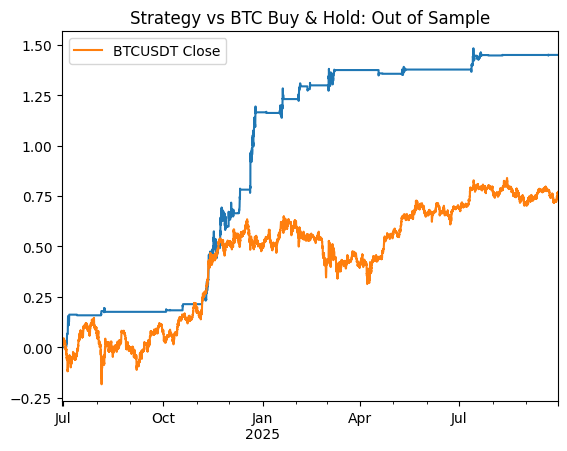

In [68]:
port_oos['20240630':].cumsum().plot()
rets_oos['BTCUSDT Close']['20240630':].cumsum().plot()
plt.title('Strategy vs BTC Buy & Hold: Out of Sample')
plt.legend()
plt.show()

In [69]:
to_oos = (strat_wgts_oos.fillna(0) - strat_wgts_oos.shift().fillna(0)).abs().sum(1)
print(f'Out of Sample Turnover: {to_oos.mean().round(3)}')

tcost_bps = 20 # (comissions + slip)
net_ret_oos = port_oos.subtract(to_oos*tcost_bps*1e-4,fill_value=0)
print(f'Out of Sample SR after t-costs: {(net_ret_oos.mean() / net_ret_oos.std() * np.sqrt(365*24)).round(2)}')

Out of Sample Turnover: 0.078
Out of Sample SR after t-costs: 2.1


### Significance Testing

In [70]:
# Significance 

# BTCUSDT returns for out-of-sample period
X = rets_oos['BTCUSDT Close']['20240630':].fillna(0)

# Portfolio returns for same period
Y = port_oos.loc[X.index]

X = sm.add_constant(X)

# Run regression
result = sm.OLS(Y, X).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     40.69
Date:                Thu, 20 Nov 2025   Prob (F-statistic):           1.86e-10
Time:                        08:43:10   Log-Likelihood:                 45120.
No. Observations:               10969   AIC:                        -9.024e+04
Df Residuals:                   10967   BIC:                        -9.022e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0001   3.78e-05      3.411

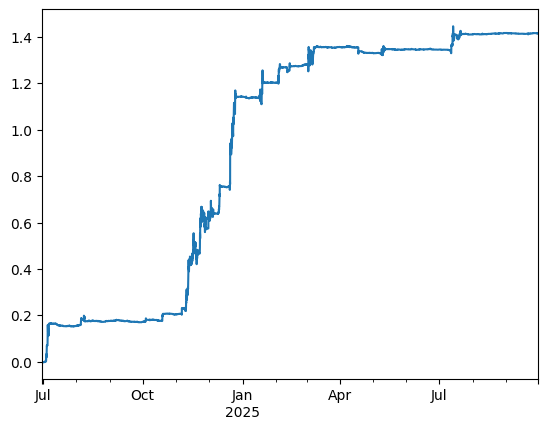

Alpha corr. to Beta: 0.0
Alpha IR:3.05


In [71]:
alpha_contr=result.params['const'] + result.resid
alpha_contr.cumsum().plot()
plt.show()
print(f'Alpha corr. to Beta: {(alpha_contr.corr(X['BTCUSDT Close'])).round(2)}')
alpha_contr.mean()
print(f'Alpha IR:{((alpha_contr.mean()/alpha_contr.std()*np.sqrt(365*24))).round(2)}')